In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm as tqdm_notebook
import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
# import importlib
from IPython.display import display, HTML
import pandas as pd
import pickle

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb
from src.stokes_flow import problem_dic, obj_dic
from src.geo import *
from src import stokes_flow as sf

from sympy.parsing import mathematica
import sympy
from sympy.printing.latex import LatexPrinter, print_latex
from sympy.utilities.lambdify import lambdify, lambdastr
import inspect

# %matplotlib notebook
%matplotlib inline
rc('animation', html='html5')
PWD = os.getcwd()

## sphere case

In [59]:
radius = 1
deltaLength = 0.3
epsilon = -1
u = 1
fileHandle = 'sphere'
solve_method = 'gmres'
precondition_method = 'none'
plot = False
debug_mode = False
matrix_method = 'pf'
restart = False
twoPara_n = 1
legendre_m = 3
legendre_k = 2
n_sphere_check = 2000
n_node_threshold = 10000
random_velocity = False
getConvergenceHistory = False
pickProblem = False

n_obj = 1
n_obj_x = 1
n_obj_y = 1
distance = 3
distance_x = distance
distance_y = distance
move_delta = np.array([distance_x, distance_y, 1])
# field_range: describe a sector area.
field_range = np.array([[-3, -3, -3], [n_obj_x - 1, n_obj_y - 1, 0] * move_delta + [3, 3, 3]])
n_grid = np.array([n_obj_x, n_obj_y, 1]) * 91

problem_kwargs = {'name':                  'spherePrb',
                  'matrix_method':         'pf',
                  'deltaLength':           deltaLength,
                  'epsilon':               epsilon,
                  'delta':                 deltaLength * epsilon,  # for rs method
                  'd_radia':               deltaLength / 2,  # for sf method
                  'solve_method':          solve_method,
                  'precondition_method':   precondition_method,
                  'field_range':           field_range,
                  'n_grid':                n_grid,
                  'plot':                  plot,
                  'debug_mode':            debug_mode,
                  'fileHandle':            fileHandle,
                  'region_type':           'rectangle',
                  'twoPara_n':             twoPara_n,
                  'legendre_m':            legendre_m,
                  'legendre_k':            legendre_k,
                  'radius':                radius, 'u': u,
                  'random_velocity':       random_velocity,
                  'n_obj_x':               n_obj_x,
                  'n_obj_y':               n_obj_y,
                  'move_delta':            move_delta,
                  'restart':               restart,
                  'n_sphere_check':        n_sphere_check,
                  'n_node_threshold':      n_node_threshold,
                  'getConvergenceHistory': getConvergenceHistory,
                  'pickProblem':           pickProblem,
                  'plot_geo':              False, }

In [87]:
fileHandle = problem_kwargs['fileHandle']
radius = problem_kwargs['radius']
deltaLength = problem_kwargs['deltaLength']
matrix_method = problem_kwargs['matrix_method']
pickProblem = problem_kwargs['pickProblem']
epsilon = problem_kwargs['epsilon']
delta = problem_kwargs['delta']
u = problem_kwargs['u']
# sphere_velocity = np.array((u, 0, 0, 0, 0, 0))
sphere_velocity = np.array((0, 0, 0, 0, 0, u))

# n = int(16 * radius * radius / deltaLength / deltaLength)
sphere_geo0 = sphere_geo()  # force geo
# sphere_geo0.create_n(n, radius)
sphere_geo0.create_delta(deltaLength, radius)
sphere_geo0.set_rigid_velocity(sphere_velocity)

problem = problem_dic[matrix_method](**problem_kwargs)
obj_sphere = obj_dic[matrix_method]()
sphere_geo1 = sphere_geo0.copy()
if matrix_method in ('pf',):
    sphere_geo1.node_zoom((radius + deltaLength * epsilon) / radius)
obj_sphere_kwargs = {'matrix_method': matrix_method,
                     'epsilon':       epsilon,
                     'delta':         delta, }
obj_sphere.set_data(sphere_geo1, sphere_geo0, name='sphereObj_0_0', **obj_sphere_kwargs)
problem.add_obj(obj_sphere)
problem.print_info()
problem.create_matrix()
problem.solve()

0.0001103606970242881

In [88]:
region_type = problem_kwargs['region_type']
field_range = problem_kwargs['field_range']
n_grid = problem_kwargs['n_grid']

temp_x, temp_y = np.meshgrid(np.linspace(field_range[0, 0], field_range[1, 0], n_grid[0]), 
                                           np.linspace(field_range[0, 1], field_range[1, 1], n_grid[1]))
temp_z = np.zeros_like(temp_x)
obj0 = sf.StokesFlowObj()
temp_nodes = np.c_[temp_x.ravel(), temp_y.ravel(), temp_z.ravel()]
temp_geo = base_geo()
temp_geo.set_nodes(temp_nodes, resetVelocity=True, deltalength=0)
obj0.set_data(temp_geo, temp_geo)
obju = problem.solve_obj_u(obj0)
u_x = obju[0::3].reshape(temp_x.shape)
u_y = obju[1::3].reshape(temp_x.shape)
u_z = obju[2::3].reshape(temp_x.shape)
temp_r = np.sqrt(temp_x ** 2 + temp_y ** 2 + temp_z ** 2)
tidx = temp_r < radius
u_x[tidx] = np.nan
u_y[tidx] = np.nan
u_z[tidx] = np.nan

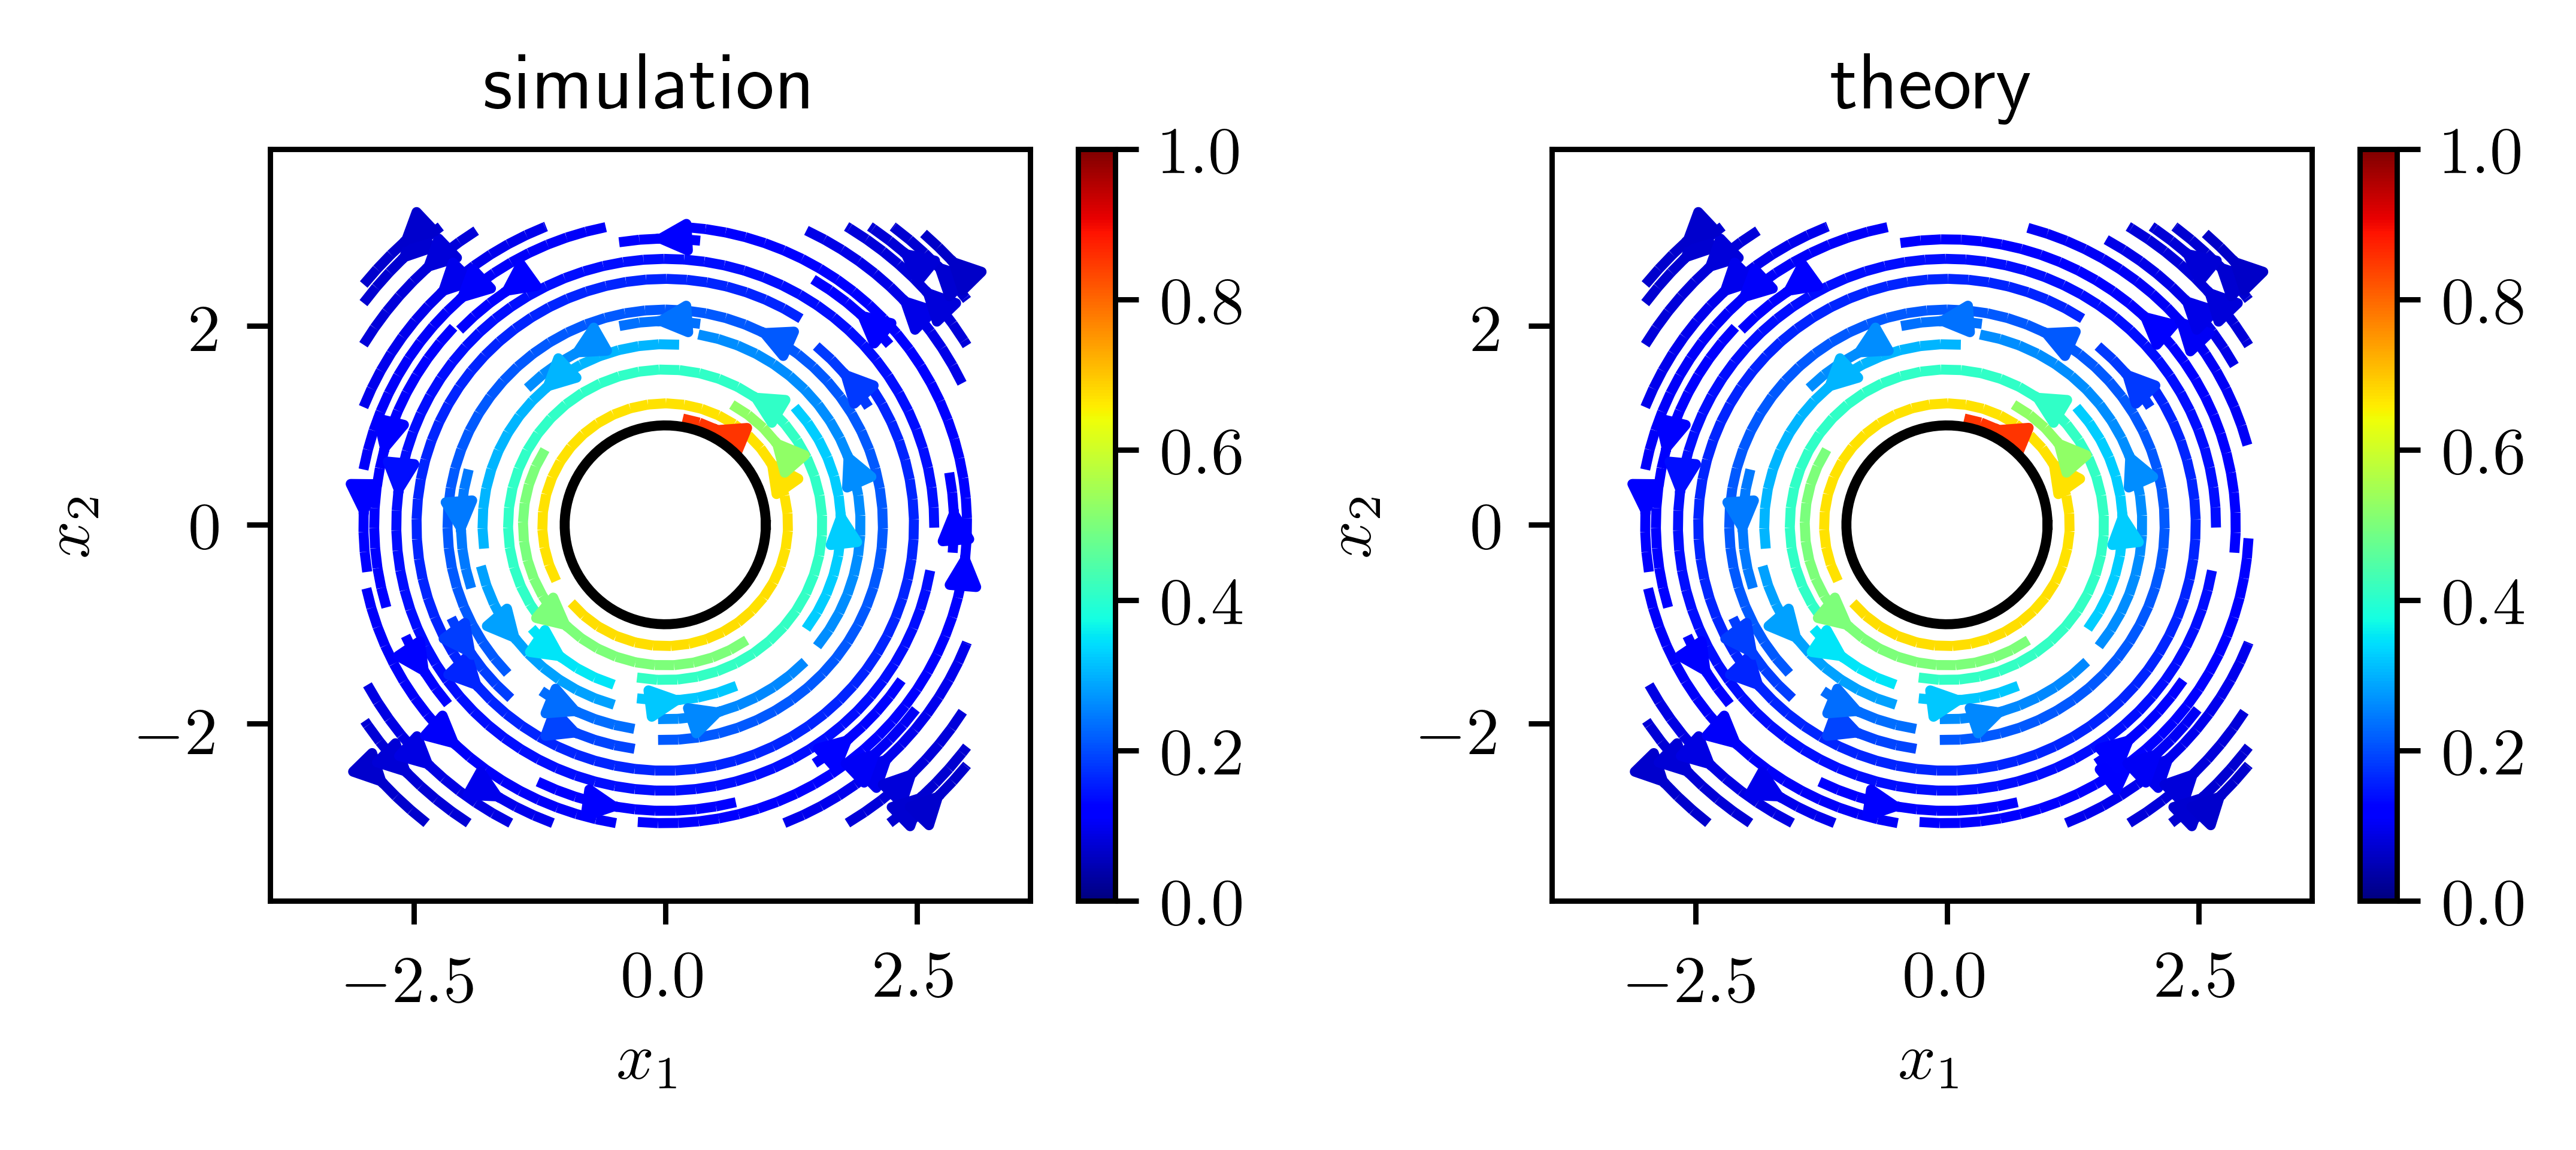

In [89]:
def sphereAnaTrs(temp_x, temp_y, radius):
    temp_r = np.sqrt(temp_x ** 2 + temp_y ** 2)
    sinTheta = temp_y / temp_r
    cosTheta = temp_x / temp_r
    vr = u * cosTheta * ((3 / 2) * (radius / temp_r) - (1 / 2) *  (radius / temp_r) ** 3)
    vt = -u * sinTheta * ((3 / 4) * (radius / temp_r) + (1 / 4) *  (radius / temp_r) ** 3)
    ux = vr * cosTheta - vt * sinTheta
    uy = vr * sinTheta + vt * cosTheta
    tidx = temp_r < radius
    ux[tidx] = np.nan
    uy[tidx] = np.nan
    return ux, uy

def sphereAnaRot(temp_x, temp_y, radius):
    temp_r = np.sqrt(temp_x ** 2 + temp_y ** 2)
    ux = -temp_y * (radius / temp_r) ** 3
    uy = temp_x * (radius / temp_r) ** 3
    tidx = temp_r < radius
    ux[tidx] = np.nan
    uy[tidx] = np.nan
    return ux, uy

figsize = np.array((11, 5)) * 0.5
dpi = 800
norm = plt.Normalize(0, 1)
cmap = plt.get_cmap('jet')
# sphereAnaFun = sphereAnaTrs
sphereAnaFun = sphereAnaRot

fig, axs = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi = axs[0]
lw = np.sqrt(u_x ** 2 + u_y ** 2)
im = axi.streamplot(temp_x, temp_y, u_x, u_y, color=lw, norm=norm, cmap=cmap)
t = np.linspace(0, 2*np.pi, 100)
x = radius * np.cos(t)
y = radius * np.sin(t)
axi.plot(x, y, 'k-')
fig.colorbar(im.lines, ax=axi)
axi.set_xlabel('$x_1$')
axi.set_ylabel('$x_2$')
axi.set_title('simulation')
spf.set_axes_equal(axi)

axi = axs[1]
ux, uy = sphereAnaFun(temp_x, temp_y, radius)
lw = np.sqrt(ux ** 2 + uy ** 2)
im = axi.streamplot(temp_x, temp_y, ux, uy, color=lw, norm=norm, cmap=cmap)
t = np.linspace(0, 2*np.pi, 100)
x = radius * np.cos(t)
y = radius * np.sin(t)
axi.plot(x, y, 'k-')
fig.colorbar(im.lines, ax=axi)
axi.set_xlabel('$x_1$')
axi.set_ylabel('$x_2$')
axi.set_title('theory')
spf.set_axes_equal(axi)

plt.tight_layout()

## Jeffery orbit


ShearJefferyProblem: run 300000 loops using 70.340909


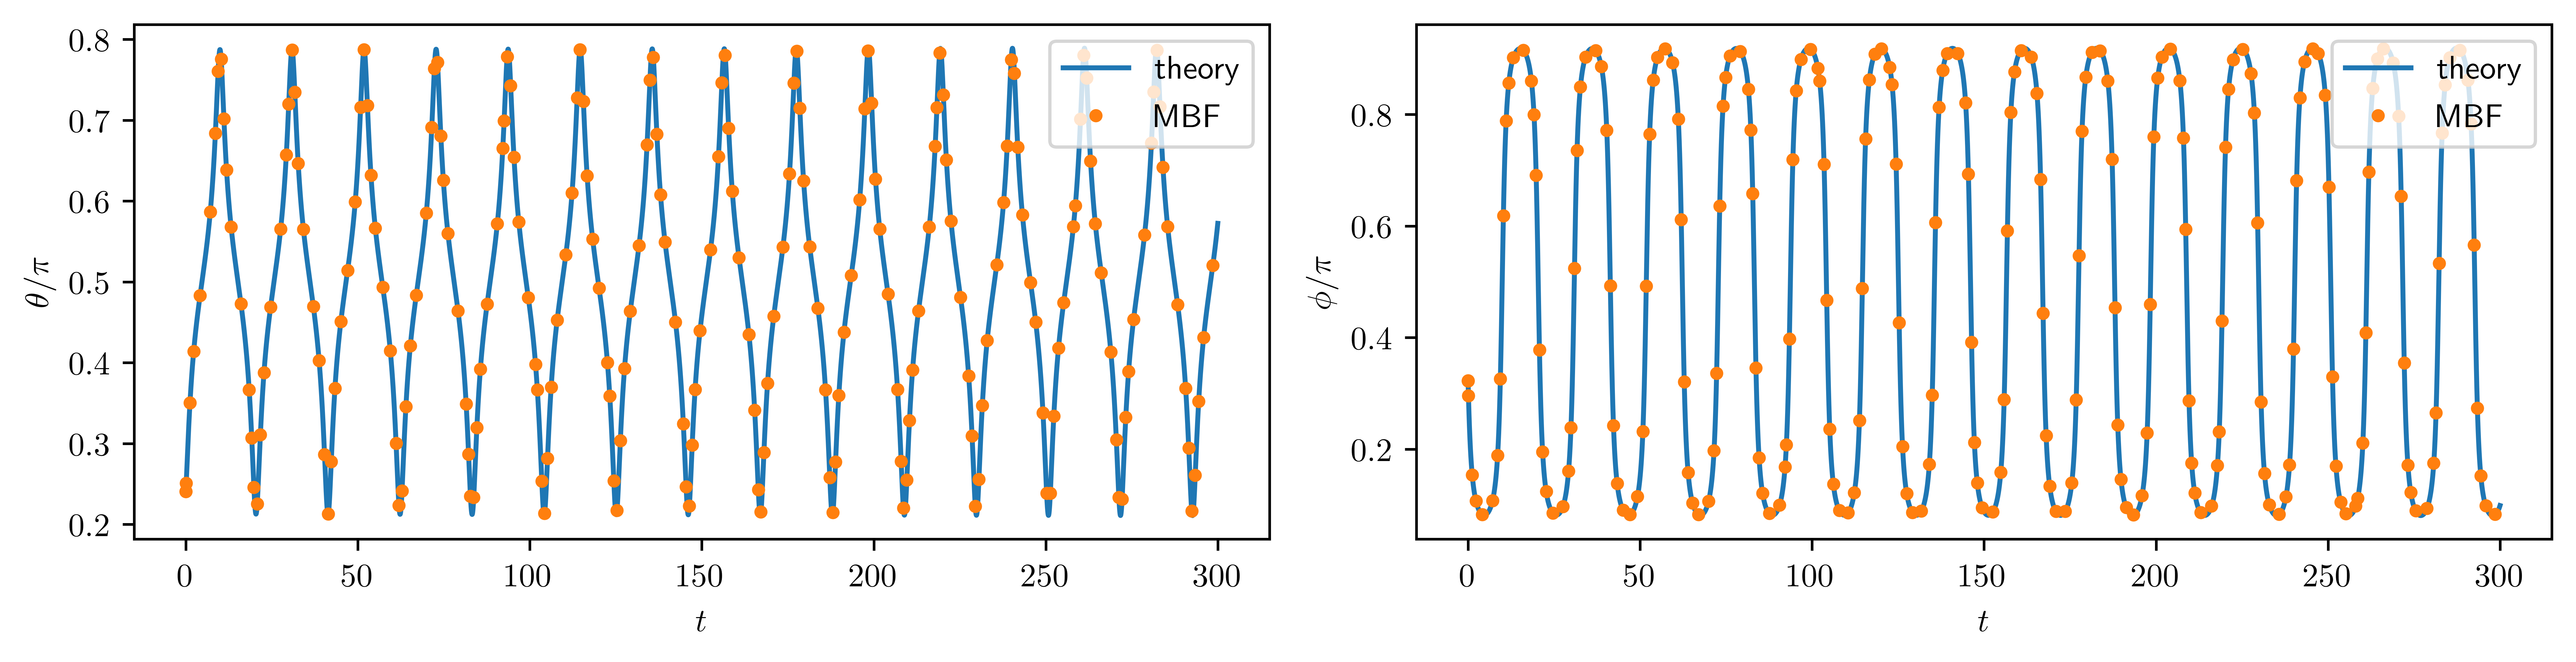

In [66]:
from src import jeffery_model as jm

fileHandle = 'ShearJefferyProblem'
eval_dt = 0.001
max_iter = 3* 10 ** 5
ellipse_velocity = 0
rot_speed = 0
planeShearRate = (1, 0, 0)
talpha = 3
figsize = np.array((22, 5.8)) * 0.5
dpi = 800
table_name = 'ellipsoidB05_baseFlow_mdf'
update_fun='5bs'
rtol=1e-6
atol=1e-9
save_every = 1
omega_tail = 0

# generate objs
tnorm = np.random.sample(3)
tnorm = tnorm / np.linalg.norm(tnorm)
tlateral_norm = np.array((np.pi, np.e, np.euler_gamma))
tlateral_norm = tlateral_norm / np.linalg.norm(tlateral_norm)
tlateral_norm = tlateral_norm - tnorm * np.dot(tnorm, tlateral_norm)
tlateral_norm = tlateral_norm / np.linalg.norm(tlateral_norm)
tcenter = np.zeros(3)
tlbd = (talpha ** 2 - 1) / (talpha ** 2 + 1)

problem = jm.ShearJefferyProblem(planeShearRate=planeShearRate)
ellipse_kwargs = {'name':          fileHandle,
                  'center':        tcenter,
                  'rot_speed':     rot_speed,
                  'norm':          tnorm / np.linalg.norm(tnorm),
                  'lateral_norm':  tlateral_norm / np.linalg.norm(tlateral_norm),
                  'speed':         ellipse_velocity,
                  'lbd':           (talpha ** 2 - 1) / (talpha ** 2 + 1)}
ellipse_obj = jm.JefferyObj(**ellipse_kwargs)
problem.add_obj(ellipse_obj)

# evaluation loop
t0 = time()
for idx in tqdm_notebook(range(1, max_iter + 1)):
    problem.update_location(eval_dt, print_handle='%d / %d' % (idx, max_iter))
t1 = time()
print('%s: run %d loops using %f' % (fileHandle, max_iter, (t1 - t0)))
t0 = np.arange(max_iter) * eval_dt + eval_dt
# center_hist = np.vstack(ellipse_obj.center_hist)
# U_hist = np.vstack(ellipse_obj.U_hist)
# norm_hist = np.vstack(ellipse_obj.norm_hist)
# lateral_norm_hist = np.vstack(ellipse_obj.lateral_norm_hist)
jeffery_theta, jeffery_phi, jeffery_psi = ellipse_obj.theta_phi_psi

# simulation 
t_psi = jeffery_psi[0]
max_t = max_iter * eval_dt
flow_strength = np.linalg.norm(planeShearRate)
Table_t, Table_dt, Table_X, Table_P, Table_P2, Table_theta, Table_phi, Table_psi, Table_eta \
   = spf_tb.do_ShearFlowPetsc4nPsiObj(tnorm, t_psi, max_t, update_fun=update_fun, 
                                      rtol=rtol, atol=atol, eval_dt=eval_dt, 
                                      save_every=save_every, table_name=table_name, 
                                      omega_tail=omega_tail, flow_strength=flow_strength)

# show
markevery = Table_t.size // 200
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi = axs[0]
axi.plot(t0, jeffery_theta / np.pi, '-', label='theory')
axi.plot(Table_t, Table_theta / np.pi, '.', markevery=markevery, label='MBF')
axi.set_xlabel('$t$')
axi.set_ylabel('$\\theta / \pi$')
axi.legend(loc='upper right')
axi = axs[1]
axi.plot(t0, jeffery_phi / np.pi, '-', label='theory')
axi.plot(Table_t, Table_phi / np.pi, '.', markevery=markevery, label='MBF')
axi.set_xlabel('$t$')
axi.set_ylabel('$\\phi / \pi$')
axi.legend(loc='upper right')
plt.tight_layout()

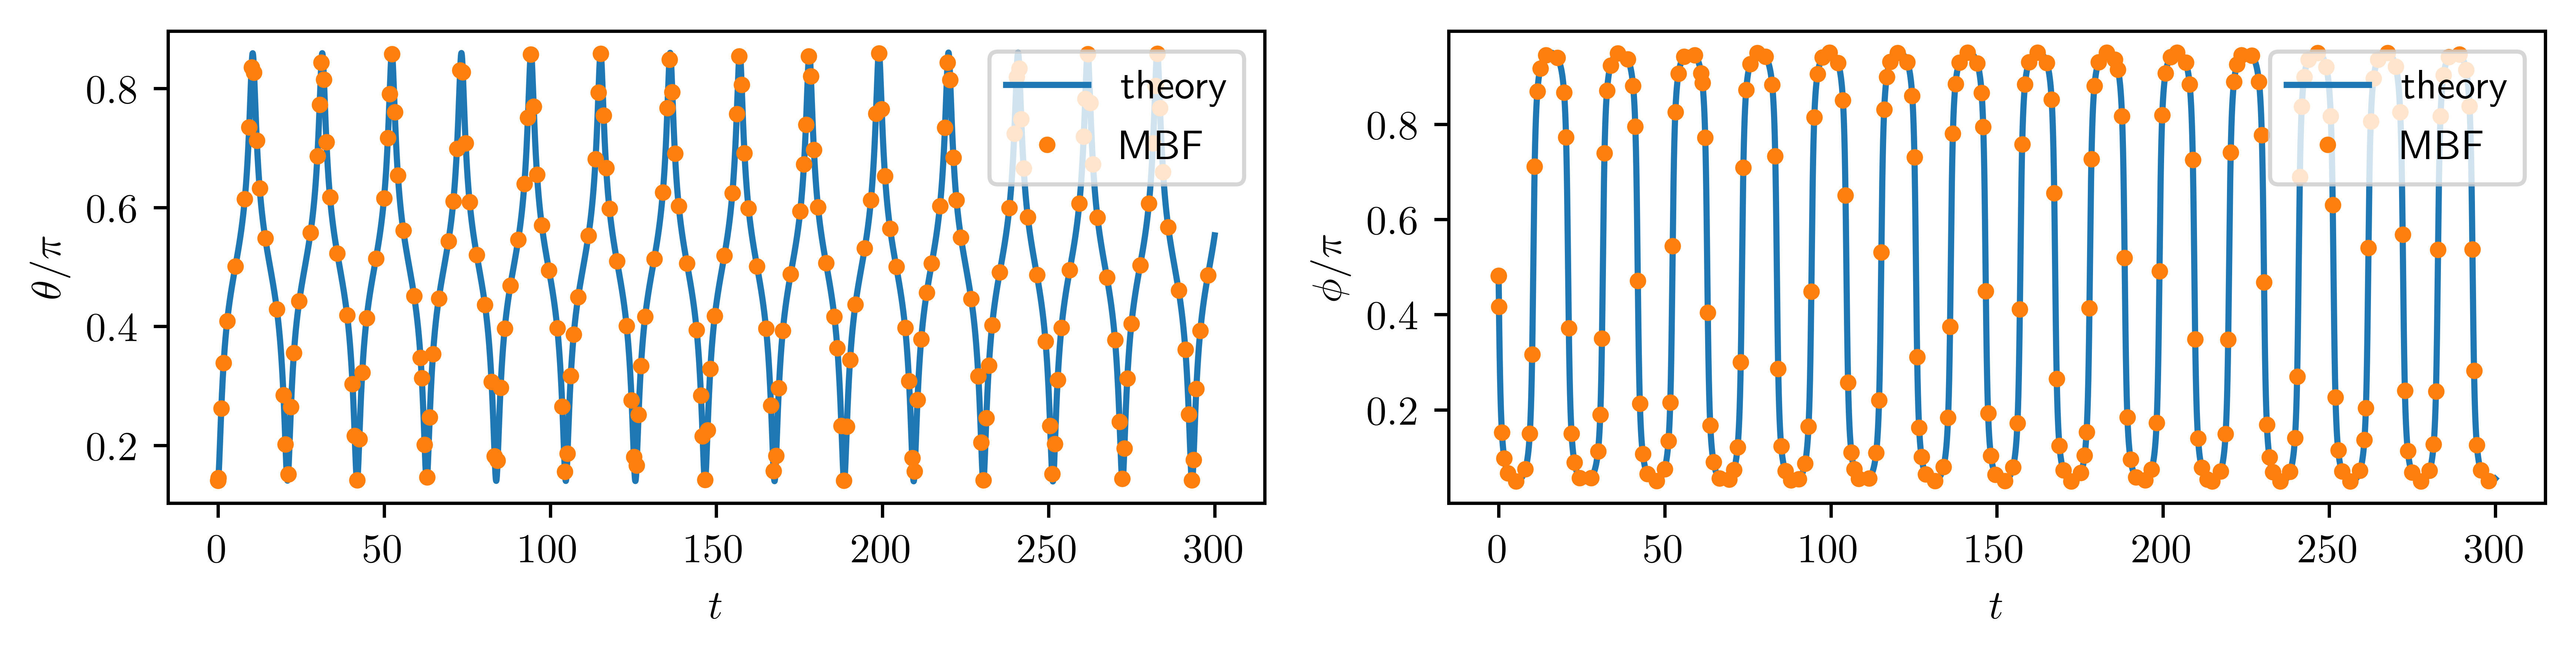

In [65]:
# rtol = 1e-6
# atol = 1e-9

# # simulation 
# t_psi = jeffery_psi[0]
# max_t = max_iter * eval_dt
# flow_strength = np.linalg.norm(planeShearRate)
# Table_t, Table_dt, Table_X, Table_P, Table_P2, Table_theta, Table_phi, Table_psi, Table_eta \
#    = spf_tb.do_ShearFlowPetsc4nPsiObj(tnorm, t_psi, max_t, update_fun=update_fun, 
#                                       rtol=rtol, atol=atol, eval_dt=eval_dt, 
#                                       save_every=save_every, table_name=table_name, 
#                                       omega_tail=omega_tail, flow_strength=flow_strength)

# show


figsize = np.array((22, 5.8)) * 0.4
dpi = 800
markevery = Table_t.size // 200
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi = axs[0]
axi.plot(t0, jeffery_theta / np.pi, '-', label='theory')
axi.plot(Table_t, Table_theta / np.pi, '.', markevery=markevery, label='MBF')
axi.set_xlabel('$t$')
axi.set_ylabel('$\\theta / \pi$')
axi.legend(loc='upper right')
axi = axs[1]
axi.plot(t0, jeffery_phi / np.pi, '-', label='theory')
axi.plot(Table_t, Table_phi / np.pi, '.', markevery=markevery, label='MBF')
axi.set_xlabel('$t$')
axi.set_ylabel('$\\phi / \pi$')
axi.legend(loc='upper right')
plt.tight_layout()

In [61]:
Table_t.size

436